# Discovering chemicals in patents by assessing their findability
 Prevalent sections in patent documents capturing compound information

# Import Modules

In [1]:
import os
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

tqdm.pandas()

# Add path constants

In [2]:
FIG_DIR = "../data/figures"
PROCESSED_DIR = "../data/processed"
os.makedirs(FIG_DIR, exist_ok=True)

# Load data file

In [3]:
surechembl_df = pd.read_parquet(
    f"{PROCESSED_DIR}/surechembl_unique_inchikey_dump.pq.gzip"
)
surechembl_df.head(2)

,SureChEMBL_ID,SMILES,InChIKey,PATENT_ID,PUBLICATION_DATE,Field,year
0,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,EP-2842582-A2,2015-03-04,Description,2015
1757,SCHEMBL9,O=C(O)\C=C/C(=O)O.CCOC(=O)[C@H](CCC1=CC=CC=C1)...,OYFJQPXVCSSHAI-QFPUQLAESA-N,EP-2838373-A2,2015-02-25,Description,2015


# Filtering unique compounds per year

In [4]:
surechembl_df["year"] = surechembl_df["PUBLICATION_DATE"].progress_apply(
    lambda x: x.split("-")[0]
)

100%|██████████| 21857225/21857225 [00:30<00:00, 714467.86it/s]


In [5]:
surechembl_df.InChIKey.nunique(), surechembl_df.shape

(10686744, (21857225, 7))

# Calculate Fields for unique compounds per year

In [6]:
patent_field_dict = defaultdict(set)

completed_molecules = set()  # to avoid counting chemicals in two different fields

for inchikey, field in tqdm(surechembl_df[["InChIKey", "Field"]].values):
    if inchikey in completed_molecules:
        continue

    patent_field_dict[field].add(inchikey)
    completed_molecules.add(inchikey)

patent_field_dict = {i: len(j) for i, j in patent_field_dict.items()}

len(patent_field_dict), len(completed_molecules)

100%|██████████| 21857225/21857225 [00:41<00:00, 526534.57it/s]


(6, 10686744)

In [7]:
field_count_df = pd.DataFrame([patent_field_dict]).T.reset_index()
field_count_df.columns = ["field", "count"]

In [8]:
rename_vals = {
    "Image (for patents after 2007)": "Image",
    "MOL Attachment (US patents after 2007)": "MOL file",
}
field_count_df["field"] = field_count_df["field"].progress_map(
    lambda x: rename_vals[x] if x in rename_vals else x
)
field_count_df.sort_values("count", ascending=False, inplace=True)
field_count_df

100%|██████████| 6/6 [00:00<00:00, 14563.56it/s]


,field,count
1,Image,5806869
0,Description,3257404
3,Claims,868523
4,MOL file,745319
2,Abstract,6542
5,Title,2087


# Visualisation

In [9]:
total_count = field_count_df["count"].sum()
total_count

10686744

In [10]:
sns.set_style("whitegrid")

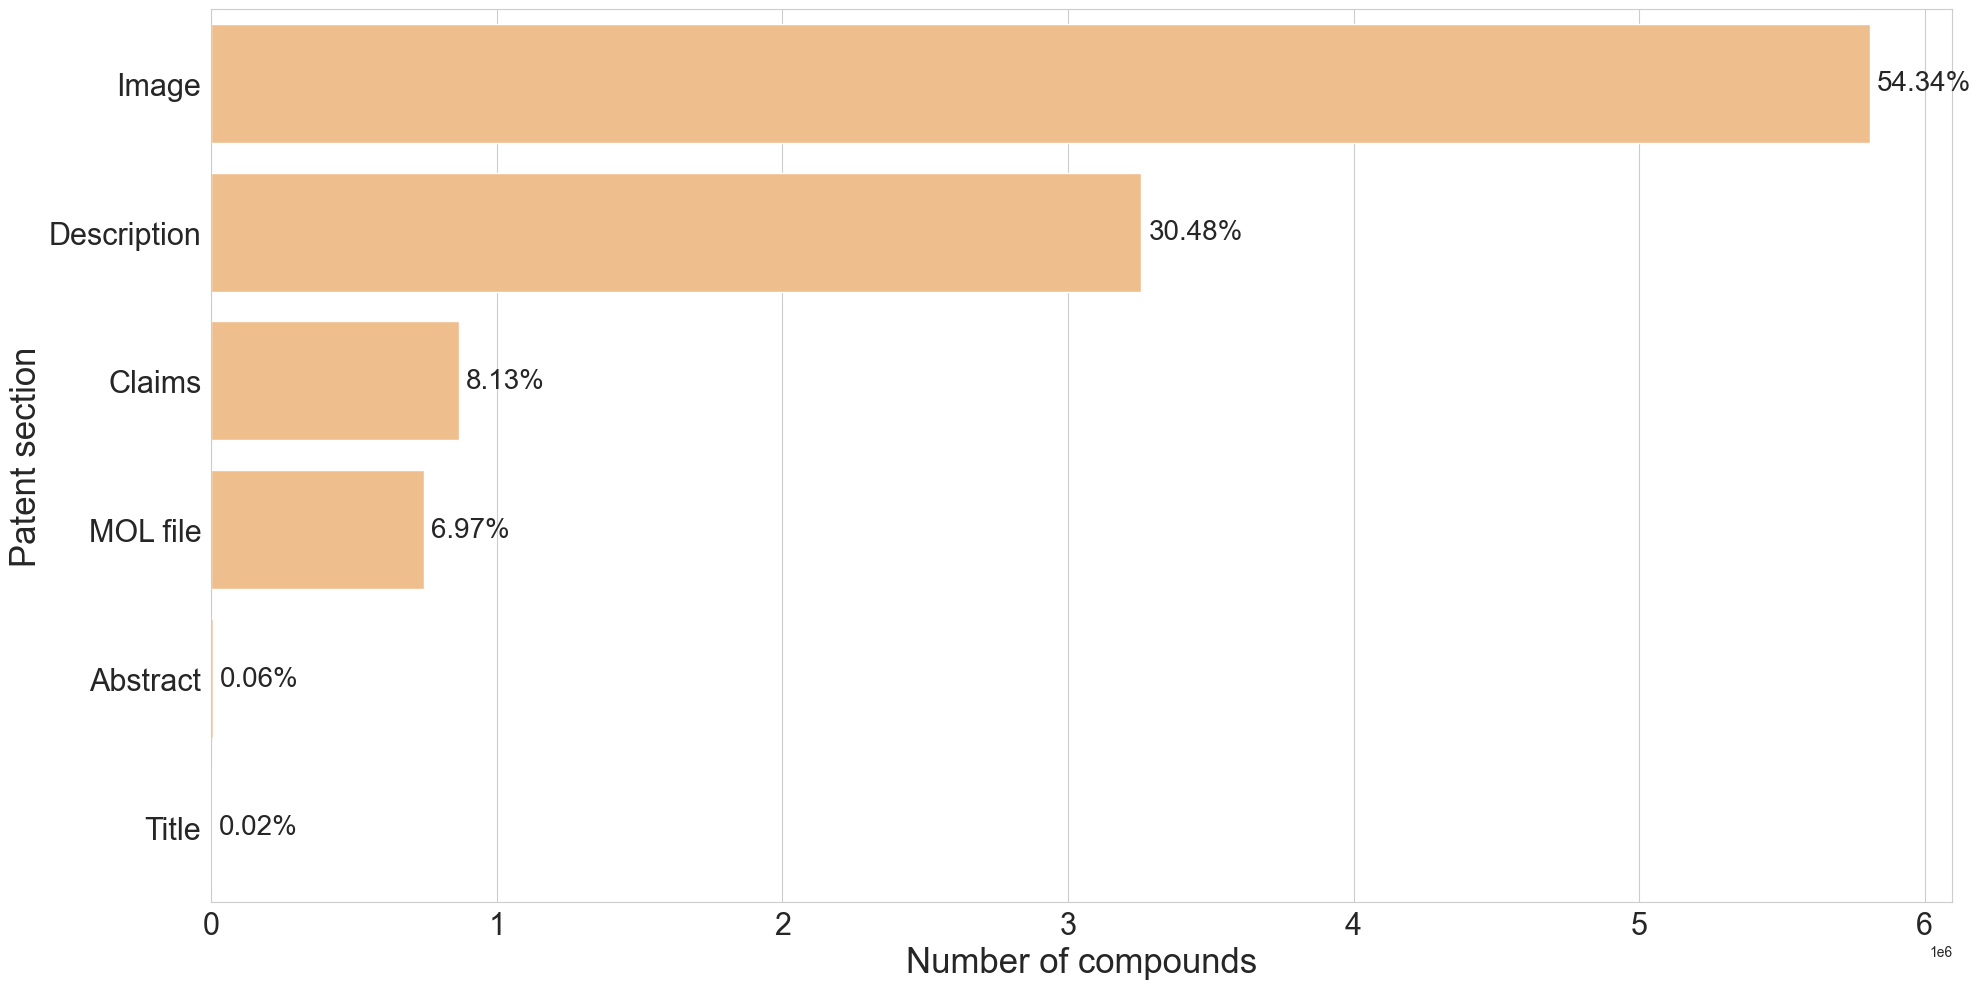

In [11]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(data=field_count_df, x="count", y="field", orient="h", color="#ffbe7d")
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Number of compounds", fontsize=25)
plt.ylabel("Patent section", fontsize=25)

for p in ax.patches:
    t = (p.get_width() / total_count) * 100
    ax.annotate(
        "%.2f" % t + "%",
        xy=(p.get_width(), p.get_y() + p.get_height() / 2),
        xytext=(5, 0),
        textcoords="offset points",
        ha="left",
        va="center",
        fontsize=20,
    )
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/figure_3.png", dpi=400)
plt.show()